In [1]:
import torch
from diffusers import AutoencoderKL
from tqdm.notebook import tqdm
import numpy as np
from transformer.microdit import MicroDiT
import matplotlib.pyplot as plt
from config import VAE_CHANNELS, DIT_S as DIT, MODELS_DIR_BASE
from torch.amp import autocast
from open_clip import create_model_from_pretrained, get_tokenizer
from diffusers import AutoencoderDC

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

In [ ]:
# vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path="madebyollin/sdxl-vae-fp16-fix", cache_dir=f"{MODELS_DIR_BASE}/vae").to(device)

In [3]:
input_dim = VAE_CHANNELS
embed_dim = 1024
num_layers = 4
num_heads = 16
mlp_dim = 2048
cond_embed_dim = 1 # Null for this dataset
# pos_embed_dim = 60
pos_embed_dim = None
num_experts = 3
active_experts = 1
shared_experts = 1
token_mixer_layers = 2
dropout = 0.1
DTYPE = torch.bfloat16

In [4]:
model = MicroDiT(input_dim, embed_dim, num_layers, 
                num_heads, mlp_dim, cond_embed_dim, cond_embed_dim,
                num_experts, active_experts, shared_experts,
                dropout, token_mixer_layers
)
model.load_state_dict(torch.load("models/microdit_model_and_optimizer_epoch_40_f32.pt")['model_state_dict'])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2436\1503291800.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/microdit_model_and_op

<All keys matched successfully>

In [5]:
model = model.to(device).to(torch.bfloat16)

In [6]:
vae = AutoencoderDC.from_pretrained("mit-han-lab/dc-ae-f32c32-in-1.0-diffusers", torch_dtype=DTYPE, cache_dir=f"{MODELS_DIR_BASE}/dc_ae", revision="main").to(device, ).eval()


In [8]:
SIGLIP_HF_NAME ="hf-hub:timm/ViT-SO400M-14-SigLIP-384"

In [ ]:
siglip_model, _ = create_model_from_pretrained(SIGLIP_HF_NAME, precision="fp16", cache_dir=f"{MODELS_DIR_BASE}/siglip")
siglip_model = siglip_model.to(device)
siglip_tokenizer = get_tokenizer(SIGLIP_HF_NAME)

In [10]:
prompts = [
    "A serene landscape with rolling hills under a vibrant sunset sky",
    "A futuristic cityscape with towering skyscrapers and flying cars",
    "A cozy cottage in a snowy forest with smoke coming from the chimney"
]

In [11]:
prompts = [
    "amateur photography, a woman showing the palms of her hands",
    "A futuristic cityscape with towering skyscrapers and flying cars, where the buildings are adorned with neon lights and digital billboards, creating a dazzling display of colors against the night sky, while sleek, aerodynamic vehicles zip through the air, leaving trails of light in their wake.",
    "A cozy cottage in a snowy forest, with smoke gently rising from the chimney, surrounded by tall pine trees laden with fresh snow, their branches glistening in the soft glow of the moonlight, as the warm light from the cottage windows spills out onto the snow-covered ground, inviting and comforting."
]

In [12]:
texts = siglip_tokenizer(prompts, context_length=siglip_model.context_length).to(device)
caption_embeddings = siglip_model.encode_text(texts)

In [7]:
caption_embeddings = torch.zeros((3, cond_embed_dim), device=device, dtype=DTYPE)

In [8]:
noise = torch.randn(3, 32, 8, 8).to(device).to(torch.bfloat16)


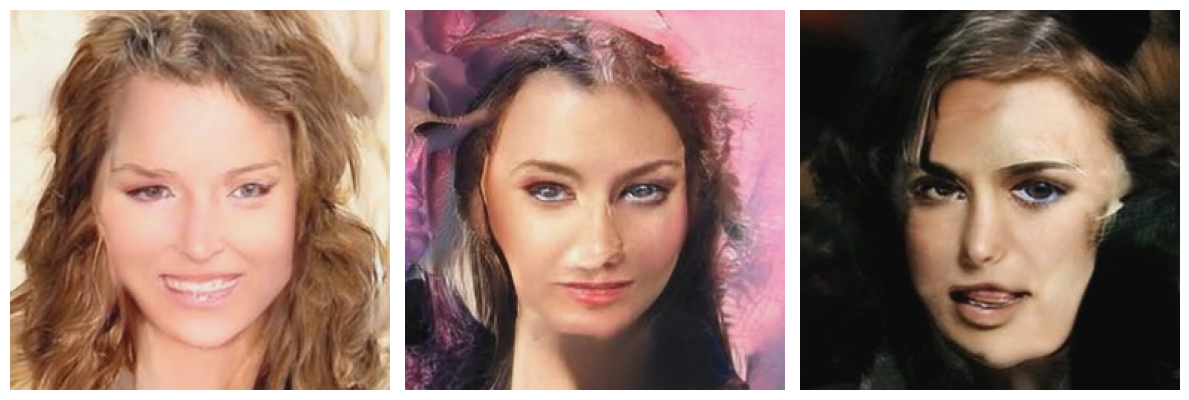

In [20]:
model = model.eval()
with autocast("cuda", dtype=torch.bfloat16):
    pred = model.sample(noise, caption_embeddings.unsqueeze(1), caption_embeddings, sample_steps=50, cfg=7.0)

    pred = vae.decode(pred).sample
    # Change range of pred from x to y to -1 to 1
    min_val = pred.min()
    max_val = pred.max()

    pred = (pred - min_val) / (max_val - min_val)
    pred = 2 * pred - 1


with torch.inference_mode():
    pred_cpu = pred.cpu().to(torch.float32)
    pred_np = pred_cpu.permute(0, 2, 3, 1).numpy()
    pred_np = (pred_np + 1) / 2
    pred_np = (pred_np * 255).astype(np.uint8)  # Convert to uint8

    # Create figure for predictions
    fig_pred, axes_pred = plt.subplots(1, 3, figsize=(12, 12))  # 3 rows, 3 columns

    # Plot predictions
    for i, ax in enumerate(axes_pred.flatten()):
        if i < pred_np.shape[0]:
            ax.imshow(pred_np[i])
            # ax.set_title(prompts[i])  # Add this line to set the title
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()